In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from src.bioreactor import *

Maximum biomass concentration: 21.64 g/l at time 4.90 hours


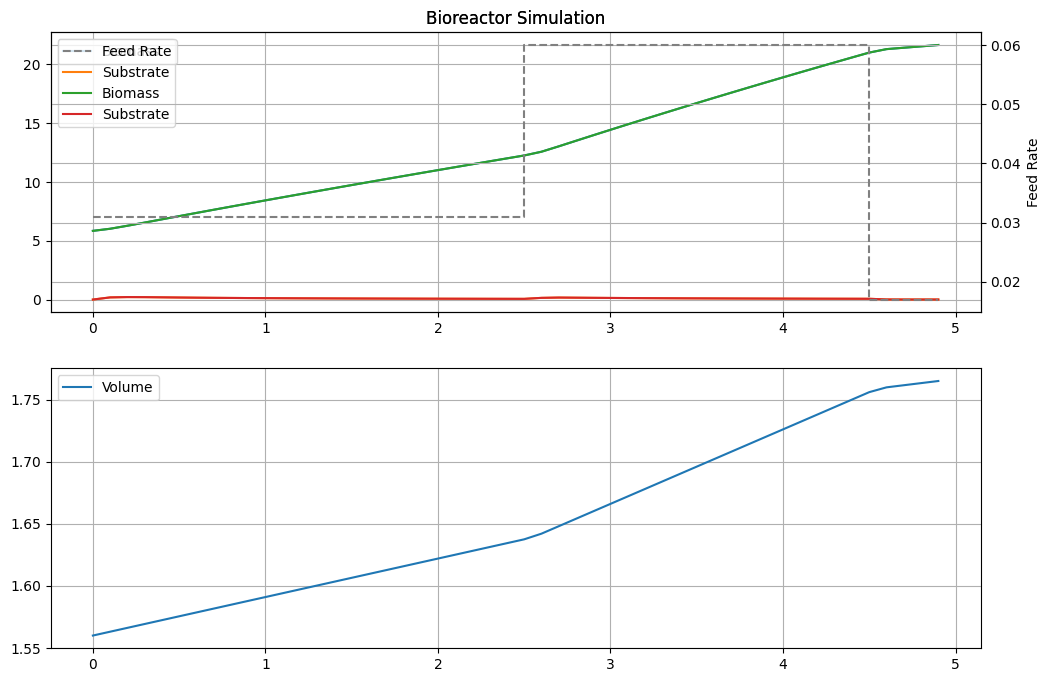

In [3]:
# inlet flowrate
def Fs(t):
    if t <= 2.5:
        return 0.031
    elif t <= 4.5:
        return 0.060
    elif t <= 4:
        return 0.031
    else:
        return 0.017

sol = simulate(Fs)

In [4]:
# Check if ../models/simple_nn.pkl exists
# If it does, load the model; if not, train the model and save it
try:
    model = pickle.load(open('./models/simple_nn.pkl', 'rb'))
except FileNotFoundError:
    X_train, y_train = generate_training_data()

    model = MLPRegressor(hidden_layer_sizes=(256,256), learning_rate='adaptive',  
                        learning_rate_init=0.001, max_iter=1000, tol=1e-6, activation='relu', 
                        batch_size=256, early_stopping=True, verbose=True)   
    model.fit(X_train, y_train)
    pickle.dump(model, open('./models/simple_nn.pkl', 'wb'))

In [5]:
X, S, V, F = mpc(model='discretized')
# X, S, V, F = mpc_pso(model)
# X, S, V, F = mpc_diff_evol(model)
# X, S, V, F = mpc(model)

  0%|          | 0/50 [00:00<?, ?it/s]/home/kostasme/ML4MPC/src/bioreactor.py:176: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  res = minimize(cost_function, F_opt_prev, args=(X[step], S[step], V[step], t, model),
 20%|██        | 10/50 [00:02<00:06,  6.58it/s]

 40%|████      | 20/50 [00:03<00:04,  6.69it/s]

 62%|██████▏   | 31/50 [00:04<00:01, 13.38it/s]

 74%|███████▍  | 37/50 [00:05<00:01,  9.29it/s]

 80%|████████  | 40/50 [00:06<00:00, 10.29it/s]

 84%|████████▍ | 42/50 [00:06<00:00,  9.36it/s]

 94%|█████████▍| 47/50 [00:06<00:00, 11.62it/s]

100%|██████████| 50/50 [00:06<00:00,  7.32it/s]

Maximum biomass concentration: 25.70 g/l at time 4.90 hours


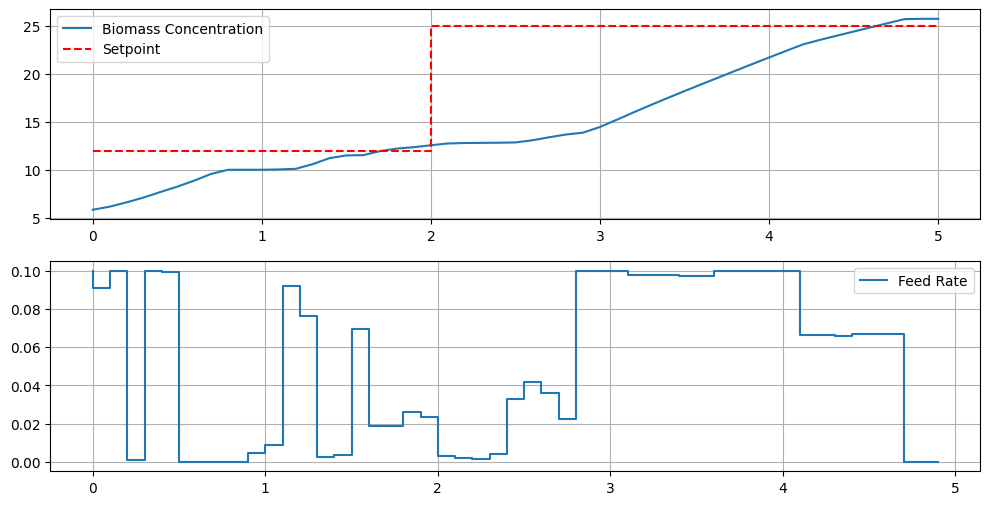

In [8]:
plot_results(X, F)

Maximum biomass concentration: 25.39 g/l at time 5.00 hours


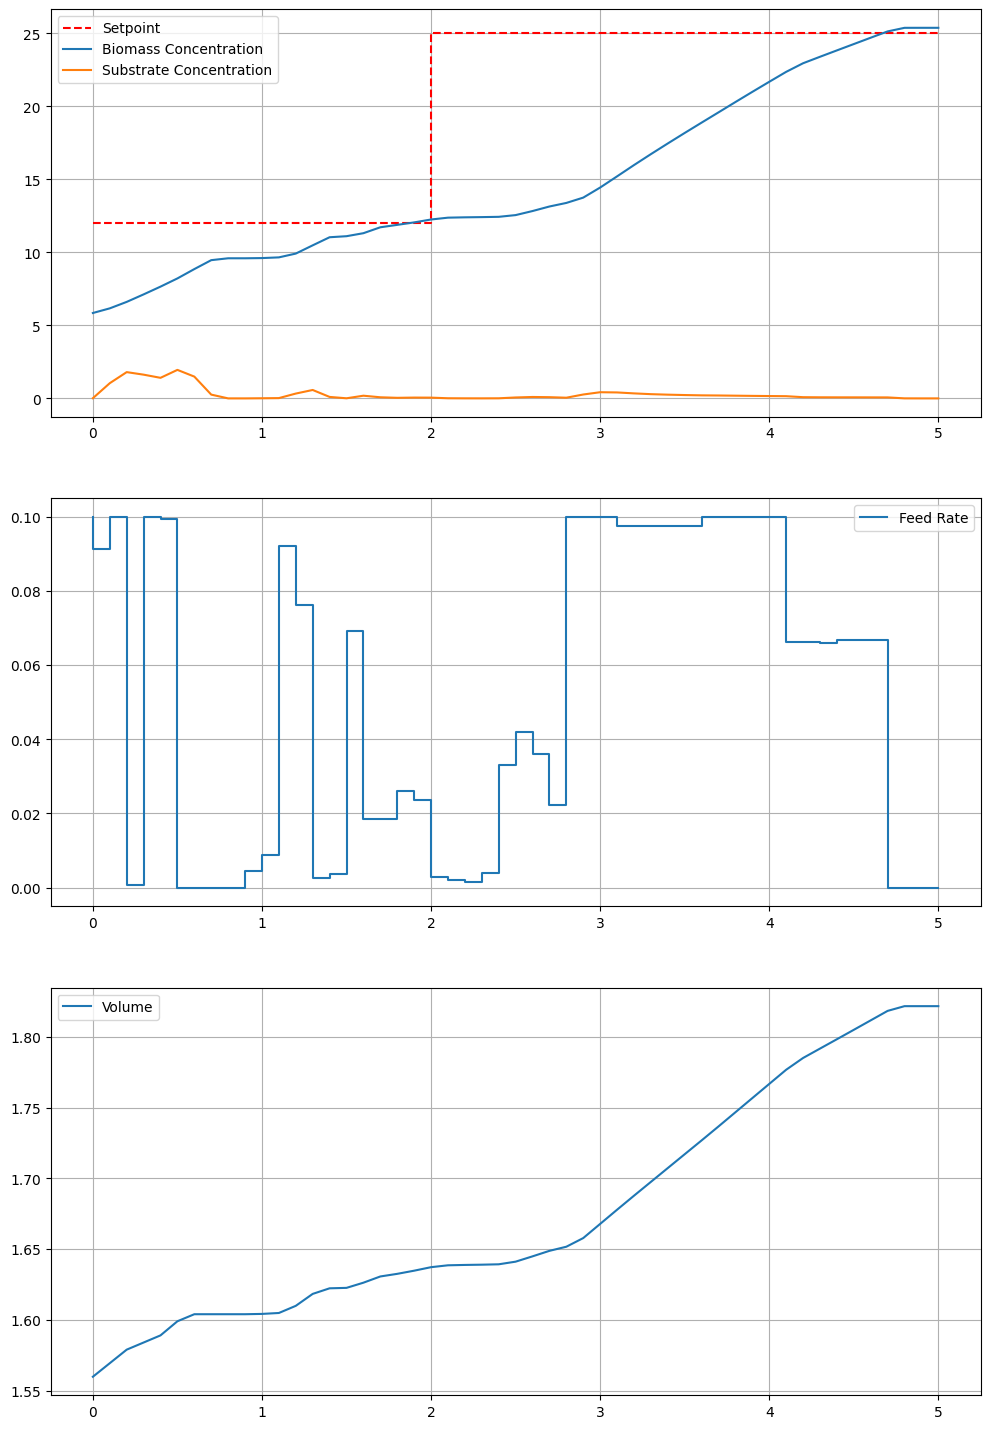

In [7]:
evaluation(F)